# 2.2 Mixture Modelos y Segmentación de Clientes de Banco 

Al igual que el task anterior, deberá construir un modelo basado en aprendizaje no supervisado para el dataset dado. 
Lo que se busca con este modelo es poder segmentar a clientes de una entidad bancaria para poder así tomar 
decisiones a nivel comercial y potenciar las operaciones de la empresa. Recuerden que: 

● Revisen la breve exploración de datos que hicieron previamente. No es necesario que lo repitan acá dado 
que ya lo hicieron antes y es el mismo dataset. Pero recuerden que: 

○ Deben seleccionar las variables para este modelo (si aplica) 

○ Tengan sus features escaladas 

● Recuerde definir de forma clara y razonada (es decir, diga el por qué de su elección) de una métrica de 
desempeño principal


In [36]:
#librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture


In [37]:
#carga de datos
df = pd.read_csv("./bank_transactions.csv")

In [38]:
#exploracion de datos
#mostrar las columanas
print("\n--Columnas:---")
print(list(df.columns))

#resumen del set de datos
print("\n--Resumen del set de datos:--")
print(df.describe())


--Columnas:---
['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance', 'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)']

--Resumen del set de datos:--
       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046198e+06     1.048567e+06             1.048567e+06
mean         1.154035e+05     1.570875e+05             1.574335e+03
std          8.464854e+05     5.126185e+04             6.574743e+03
min          0.000000e+00     0.000000e+00             0.000000e+00
25%          4.721760e+03     1.240300e+05             1.610000e+02
50%          1.679218e+04     1.642260e+05             4.590300e+02
75%          5.765736e+04     2.000100e+05             1.200000e+03
max          1.150355e+08     2.359590e+05             1.560035e+06


In [39]:
#obtener el tipo de datos
print("\n----Tipo de datos:---")
print(df.dtypes)
tipos_de_datos = df.dtypes.value_counts()
print('resumen:')
print(tipos_de_datos)


----Tipo de datos:---
TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object
resumen:
object     6
float64    2
int64      1
Name: count, dtype: int64


### Variables

TransactionID           : id de la transacción

CustomerID              : id del customer

CustomerDOB             : fecha de nacimiento del customer

CustGender              : género del cliente

CustLocation            : ubicacion del cliente

CustAccountBalance      : saldo de la cuenta del cliente

TransactionDate         : fecha de la transacción

TransactionTime         : hora de la transacción

TransactionAmount (INR) : monto de la transacción en rupias indias.


In [40]:
# Buscando valores nulls
print("- - - - - - - VALORES NULLS - - - - - - -")
nulos = df.isnull()
print(nulos)

nulos_por_columna = df.isnull().sum()
print(list(nulos_por_columna))

- - - - - - - VALORES NULLS - - - - - - -
         TransactionID  CustomerID  CustomerDOB  CustGender  CustLocation  \
0                False       False        False       False         False   
1                False       False        False       False         False   
2                False       False        False       False         False   
3                False       False        False       False         False   
4                False       False        False       False         False   
...                ...         ...          ...         ...           ...   
1048562          False       False        False       False         False   
1048563          False       False        False       False         False   
1048564          False       False        False       False         False   
1048565          False       False        False       False         False   
1048566          False       False        False       False         False   

         CustAccountBalance  Tran

In [41]:
# Elimina filas con al menos un valor nulo
df = df.dropna(axis=0)

In [42]:
df["CustGender"].value_counts()

CustGender
M    760978
F    280635
T         1
Name: count, dtype: int64

In [43]:
# Quitar T porque solo tiene un valor y es insignificante
df = df[df["CustGender"] != "T"]

# Balancear el dataset
df_majority = df[df["CustGender"] == "M"]
df_minority = df[df["CustGender"] == "F"]

df_majority_sample = df_majority.sample(n=len(df_minority), random_state=42)

df_balanced = pd.concat([df_majority_sample, df_minority])

df_balanced["CustGender"].value_counts()

CustGender
M    280635
F    280635
Name: count, dtype: int64

In [44]:
# Calcular la edad
df_balanced["CustomerDOB"] = pd.to_datetime(df_balanced["CustomerDOB"], errors="coerce")
current_year = datetime.now().year
df_balanced["Age"] = current_year - df_balanced["CustomerDOB"].dt.year

C:\Users\angel\AppData\Local\Temp\ipykernel_14460\1309165656.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_balanced["CustomerDOB"] = pd.to_datetime(df_balanced["CustomerDOB"], errors="coerce")


Objetivo: segmentar a clientes de una entidad bancaria para poder tomar desiciones a nivel comercial y potenciar las operaciones de la empresa.

Seleccionar las variables para el modelo:
- Age
- CustGender
- CustAccountBalance
- Transaction Amount (INR)

variables que podrian servir, pero en este caso no se usaran: 
- CustomerID
- CustLocation
- TransactionDate
- TransactionTime


In [45]:
# Data para usar
df_data = df_balanced[["Age", "CustAccountBalance", "CustGender", "TransactionAmount (INR)"]].copy()

df_data[["Age", "CustAccountBalance", "TransactionAmount (INR)"]] = df_data[["Age", "CustAccountBalance", "TransactionAmount (INR)"]].astype(float)
scaler = MinMaxScaler()

# Normalizar los datos
df_data.loc[:,["Age", "CustAccountBalance", "TransactionAmount (INR)"]] = scaler.fit_transform(df_data[["Age", "CustAccountBalance", "TransactionAmount (INR)"]])
df_data.loc[:,"CustGender"] = df_data["CustGender"].map({"M": 0, "F": 1})

-------------
## 2.2.1 con liberias

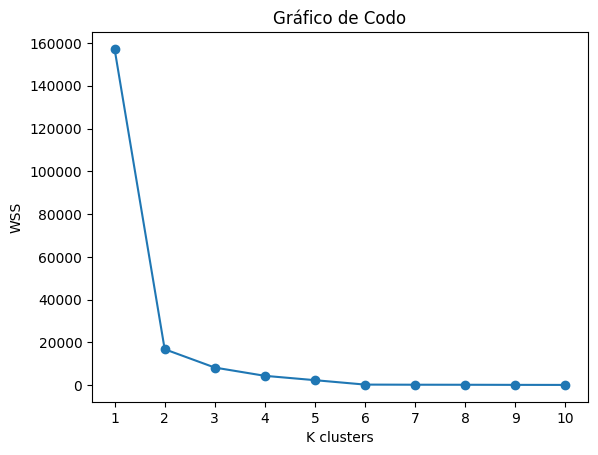

In [46]:
#saber el numero de K clusters
numeroClusters = range(1,11)
wcss = []

for i in numeroClusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_data)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss, marker='o')
plt.xticks(numeroClusters)
plt.xlabel("K clusters")
plt.ylabel("WSS")
plt.title("Gráfico de Codo")
plt.show()

En el grafico del codo, nos indica que k=2 es un buen numero para los datos, ya que la suma de wss disminuye rapidamente hasta los 2 clusters y luego se vuelve gradual.

In [47]:
#modelo de mixture models para segmentar a los clientes en la cantidad de grupos decidida.
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


n = 2
#crear y ajustar el modelo de mixture models
gmm = GaussianMixture(n_components=n, random_state=42)
gmm.fit(df_data)

#predecir los clusters para cada punto de datos
df_data["Cluster"] = gmm.predict(df_data)

centroides = gmm.means_
covarianza = gmm.covariances_
# print(covarianza)

#funcion de elipse de  covarianza para los clusters
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_patch(ellip)
    return ellip



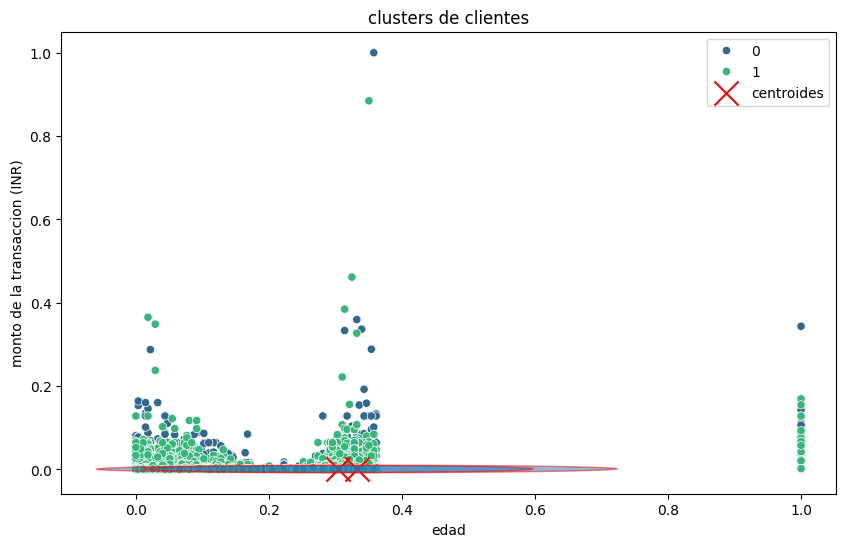

Index(['Age', 'CustAccountBalance', 'CustGender', 'TransactionAmount (INR)',
       'Cluster'],
      dtype='object')
Cluster 0:
[[5.48869843e-05 1.85610969e-06]
 [1.85610969e-06 2.01729935e-05]]
[0.00102163 0.00098372]
Cluster 1:
[[5.31034936e-05 1.22534319e-06]
 [1.22534319e-06 1.74301890e-05]]
[0.00095257 0.0010538 ]


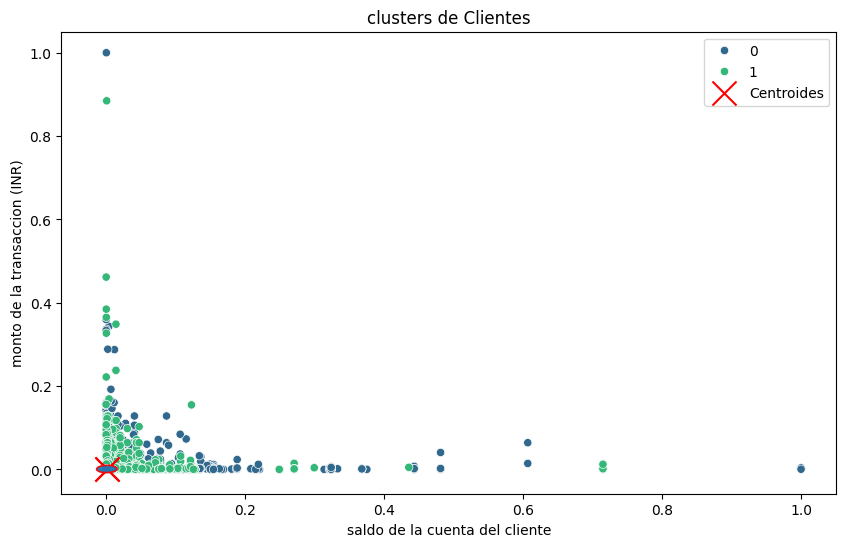

In [48]:
# visualizar los clusters 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='TransactionAmount (INR)', hue='Cluster', data=df_data, palette='viridis')
plt.scatter(centroides[:, 0], centroides[:, 3], c='red', s=300, label='centroides', marker='x')
for i in range(n):
    cov_matrix = covarianza[i][np.ix_([0, 3], [0, 3])]
    centroid_pos = centroides[i, [0, 3]]  # posicion del centroide de 'Age' y 'TransactionAmount (INR)'
    plot_cov_ellipse(cov_matrix, centroid_pos, nstd=2, alpha=0.5, edgecolor='red')
plt.title('clusters de clientes')
plt.xlabel('edad')
plt.ylabel('monto de la transaccion (INR)')
plt.legend()
plt.show()

print(df_data.columns)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='CustAccountBalance', y='TransactionAmount (INR)', hue='Cluster', data=df_data, palette='viridis')
plt.scatter(centroides[:, 1], centroides[:, 3], c='red', s=300, label='Centroides', marker='x')
for i in range(n):
    print(f"Cluster {i}:" )
    cov_matrix = covarianza[i][np.ix_([1, 3], [1, 3])]  # posiciones de CustAccountBalance y TransactionAmount (INR)
    centroid_pos = centroides[i, [1, 3]]  # posicion del centroide de CustAccountBalance y 'TransactionAmount (INR)
    print(cov_matrix)
    print(centroid_pos)
    plot_cov_ellipse(cov_matrix, centroid_pos, nstd=2, alpha=0.8, edgecolor='red')

plt.title('clusters de Clientes')
plt.xlabel('saldo de la cuenta del cliente')
plt.ylabel('monto de la transaccion (INR)')
plt.legend()
plt.show()

En el segundo gráfico se ve como si solo hubiera 1 centroide, pero como se ve en sus datos de cada cluster estan bastante cerca, por lo tanto no se ve el otro centroide.

#### PCA

c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


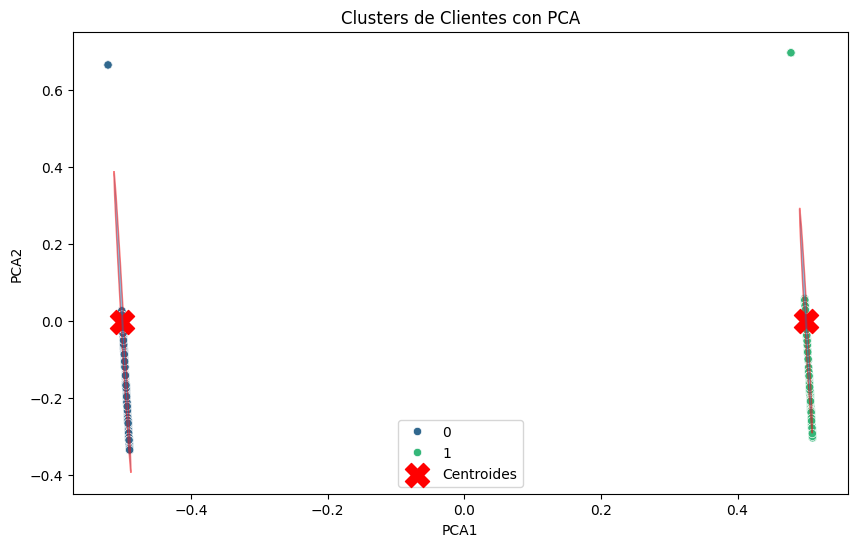

In [56]:
from sklearn.decomposition import PCA

#reducir la dimensionalidad a 2D usando PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_data.drop(columns=['Cluster', 'PCA1', 'PCA2']))

#poner los resultados en el df
df_data['PCA1'] = df_pca[:, 0]
df_data['PCA2'] = df_pca[:, 1]

# recalcular los centroieds para pca
centroides_pca = pca.transform(centroides)
# recalcular la covarianza para pca
covarianza_pca = np.array([pca.components_ @ cov @ pca.components_.T for cov in covarianza])


plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_data, palette='viridis')
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1], s=300, c='red', label='Centroides', marker='X')
for i in range(n):
    cov_matrix = covarianza_pca[i]
    centroid_pos = centroides_pca[i]
    plot_cov_ellipse(cov_matrix, centroid_pos, nstd=2, alpha=0.5, edgecolor='red')
plt.title('Clusters de Clientes con PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()



PCA definitivamente ayudo a mejorar los clusters, notandose la diferencia entre ambos. Esto es porque PCA es un metodo estadistico para transformar las caracteristicas originales de un conjunto de datos a un nuevo conjunto de caracteristicas con componentes principales. Entonces, estos componentes principales son combinaciones lineales de las variables originales y tienen las caracteristicas de: maximizar la varianza y la ortogonalidad. De esta forma, facilitando la vizualización de los datos y identificacion de patrones, clusters y relaciones que no se ve en el espacio original porque tiene una mayor dimension.

Metrica de desempeño

Silhouette Score Promedio: 0.8814224085842897


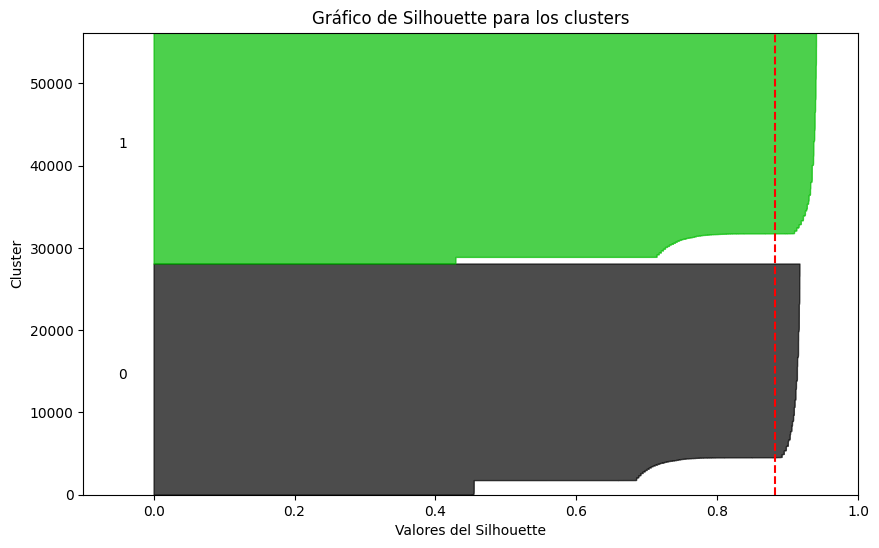

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# muestra de datos
df_sample = df_data.sample(frac=0.1, random_state=42)

#silhouette Score
silhouette_avg = silhouette_score(df_sample.drop(columns=['Cluster']), df_sample['Cluster'])
print(f"Silhouette Score Promedio: {silhouette_avg}")
#silhouette Score para cada punto
sample_silhouette_values = silhouette_samples(df_sample.drop(columns=['Cluster']), df_sample['Cluster'])


fig, ax1 = plt.subplots(figsize=(10, 6))
#rango
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(df_sample) + (n + 1) * 10]) #tamaño

y_lower = 10
for i in range(n):
    ith_cluster_silhouette_values = sample_silhouette_values[df_sample['Cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.set_title("Gráfico de Silhouette para los clusters")
ax1.set_xlabel("Valores del Silhouette")
ax1.set_ylabel("Cluster")

# linea para ver el promedio
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.show()



Como se puede ver en la gráfica y el resultado del promedio que es cercano a 1, esto nos indica que los puntos estan bien agrupados dentro de sus propios clusters y que están bien separados entre sí.